In [10]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import torch
from neuralop.data.datasets.custom_darcy import CustomDarcyDataset, load_darcy_flow
import matplotlib.pyplot as plt
from neuralop.models import CNO2d
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

In [11]:
resolution = 64
tau = 3
alpha = 2

train_loader, test_loaders, data_processor = load_darcy_flow(
    root_dir="./data/",
    dataset_name='darcy',
    n_train=1000,
    n_tests=[50],
    batch_size=100,
    test_batch_sizes=[50],
    train_resolution=resolution,
    test_resolutions=[resolution],
    train_data_setting={'tau': tau, 'alpha': alpha, 'boundary': 'ARD3'},
    test_data_settings=[{'tau': tau, 'alpha': alpha, 'boundary': 'ARD3'}],
    channels_squeezed=False
)

Loading test db for resolution 64 with 50 samples 


/home/jaeminseo/Documents/neuraloperator-main4/neuralop/data/datasets/pt_dataset.py:127: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  x_train = x_train[train_input_indices]
/home/jaeminseo/Documents/neuraloperator-main4/neuralop/data/datasets/pt_dataset.py:150: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  y_train = y

In [12]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
        
model = CNO2d(
    in_dim=3,           
    out_dim=1,       
    size=resolution,     
    N_layers=5
)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 7991849 parameters.


In [13]:
n_epochs = 200
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [14]:
import wandb
from datetime import datetime

wandb.init(
    project='Samsung_Project',
    name=f'CNO_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
)

In [15]:
trainer = Trainer(model=model, 
                  n_epochs=n_epochs,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=True,
                  eval_interval=1,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50] samples         on resolutions [64].
Raw outputs of shape torch.Size([100, 1, 64, 64])
[0] time=1.18, avg_loss=0.9057, train_err=90.5705
Eval: 64_h1=0.9744, 64_l2=0.6202
[1] time=1.16, avg_loss=0.7249, train_err=72.4870
Eval: 64_h1=0.8936, 64_l2=0.9007
[2] time=1.16, avg_loss=0.6786, train_err=67.8615
Eval: 64_h1=0.8056, 64_l2=0.8903
[3] time=1.15, avg_loss=0.6676, train_err=66.7560
Eval: 64_h1=0.7194, 64_l2=0.6443
[4] time=1.15, avg_loss=0.6619, train_err=66.1937
Eval: 64_h1=0.6666, 64_l2=0.4267
[5] time=1.15, avg_loss=0.6584, train_err=65.8379
Eval: 64_h1=0.6557, 64_l2=0.3383
[6] time=1.16, avg_loss=0.6562, train_err=65.6172
Eval: 64_h1=0.6528, 64_l2=0.2857
[7] time=1.18, avg_loss=0.6544, train_err=65.4391
Eval: 64_h1=0.6514, 64_l2=0.2778
[8] time=1.17, avg_loss=0.6522, train_err=65.2211
Eval: 64_h1=0.6529, 64_l2=0.2943
[9] time=1.17, avg_loss=0.6501, train_err=65.0116
Eval: 64_h1=0.6755, 64_l2=0.3119
[10] time=1.19, avg_loss=0.6491, train_err

{'train_err': 7.540297638796281,
 'avg_loss': 0.07540297638796281,
 'avg_lasso_loss': None,
 'epoch_train_time': 1.2333670749794692,
 '64_h1': tensor(0.7352, device='cuda:1', dtype=torch.float64),
 '64_l2': tensor(0.2630, device='cuda:1', dtype=torch.float64)}

In [17]:
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


64_h1,▁▄▂▂█▄▅▅▆▆▆▄▄▅▄▅▅▄▅▅▅▄▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
64_l2,█▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss,█▇▇▇▇▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,█████▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
time,▃▂▂▃▁▁▂▁▃▄▄▅▇▄▆▅▅▄▅▆▅▇▇▇▆█▆▇▆▇▅▅█▇▆▇▆█▇▇
train_err,█▇▇▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
64_h1,0.73522
64_l2,0.26301
avg_loss,0.0754
lr,0
time,1.23337


L2 error (0) : 0.1917570209502051
L2 error (1) : 0.3607371444294079
L2 error (2) : 0.2368228351402596


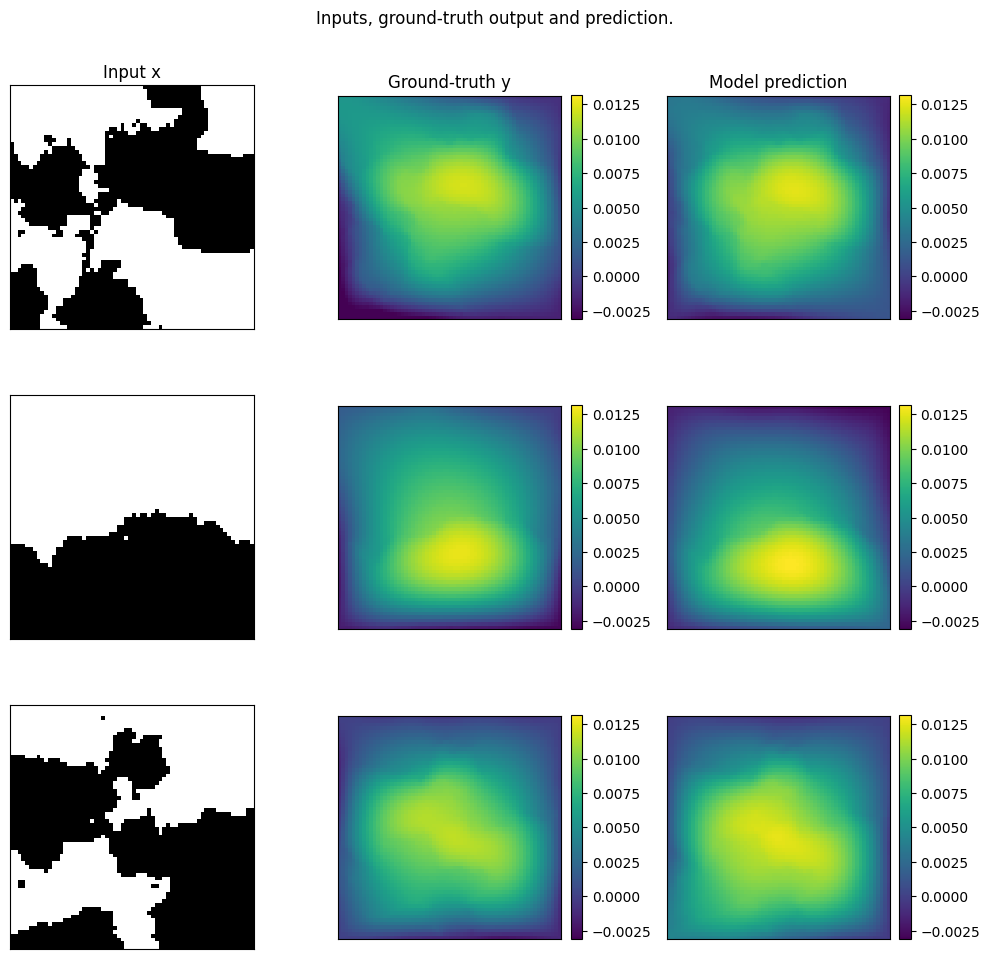

In [16]:
test_samples = test_loaders[resolution].dataset

# Step 1: Compute global min and max for consistent color scaling
vmin, vmax = float('inf'), float('-inf')
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x']
    y = data['y']
    out = model(x.unsqueeze(0))

    y = data_processor.out_normalizer.inverse_transform(y).squeeze().detach()
    out = data_processor.out_normalizer.inverse_transform(out).squeeze().detach()

    vmin = min(vmin, y.min().item(), out.min().item())
    vmax = max(vmax, y.max().item(), out.max().item())

# Step 2: Plot with consistent vmin/vmax and add colorbars
fig = plt.figure(figsize=(10, 10))

for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x'].to(device)
    y = data['y'].to(device)
    out = model(x.unsqueeze(0)).squeeze().detach()

    # y = data_processor.out_normalizer.inverse_transform(y)
    out = data_processor.out_normalizer.inverse_transform(out)

    # Input x
    ax = fig.add_subplot(3, 3, index * 3 + 1)
    im = ax.imshow(x[0].cpu(), cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])
    
    # Ground-truth y
    ax = fig.add_subplot(3, 3, index * 3 + 2)
    im = ax.imshow(y.squeeze().cpu(), vmin=vmin, vmax=vmax)
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Model prediction
    ax = fig.add_subplot(3, 3, index * 3 + 3)
    im = ax.imshow(out.squeeze().cpu(), vmin=vmin, vmax=vmax)
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    print(f'L2 error ({index}) : {torch.norm(out - y) / torch.norm(y)}')

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
plt.show()